# Data Analysis Plan: Dog Adoption
- Madison Weiss
- Sean Ayoub
- Willem Lenig
- Grace Brueckner

There is an increased urgency to adopt pets in the United States, from an increase in the supply of adoptable pets after the pandemic ended, to an increase in extreme climate events, and negative conditions in existing pet shelters. 

The pandemic brought an unforeseen rise in pet ownership in the United States. We saw an upsurge in many first-time owners as people confined to their homes. Unfortunately, this trend proved to be short-lived. As the cost of living skyrocketed, numerous pet owners were compelled to part with their beloved companions, spurring a national adoption crisis. 

The Humane Society of the United States estimates that 2.4 million healthy, adoptable cats and dogs are euthanized each year in the US because of a lack of homes. And at some no-kill shelters, "unplaceable" animals end up confined to cages for years. There is a moral obligation to ensure the well-being of animals. Many pets in shelters are abandoned, abused, or neglected, and adopting them provides a chance for a better life. Coupled with the fact that the pet population is often far greater than the demand for pets, this leads to overcrowded shelters and, in many cases, euthanizing animals due to a lack of resources. 

Additionally, pets are displaced during natural disasters such as hurricanes and tornadoes. As we see the increasing effects of climate change, this trend will only continue. According to an [NPR article](https://www.npr.org/2017/12/29/574598877/no-easy-answer-to-growing-number-of-stray-dogs-in-the-u-s-advocate-says), after Hurricane Harvey, thousands of dogs were rescued from floodwaters in Houston. 

Thankfully, websites like Petfinder have made information about adoptable animals more accessible than ever, providing a large collection of organizations that users can explore. Here is the problem, with such a wide array of animals to choose from, how can we promote fair adoption? How can we ensure that we advertise animals who are less likely to be adopted, and how can we predict this information? For this project, we intend to investigate this issue. 

Questions:
- What physical attributes of a dog have the most major effect in influencing the amount of time it takes for that pet to be adopted?  
- What behavioral attributes of a dog have the most major effect in influencing the amount of time it takes for that pet to be adopted?

# Pipeline Overview

`oauth_access_token()`:
The PetFinder API uses OAuth to authenticate API clients. An access token is required, so first we must contact the OAuth endpoint and request one.
This access token expires after an hour, so during each session a new one must be requested.

`fetch_dogs()`:
Use the access token to pull data on adopted dogs from the PetFinder API
We used the parameters status = “adopted” to only pull data for dogs that have been adopted, and the parameters after=”2022-01-01” and before=”2023-11-6” so that we can pull data from the beginning of 2022 to current day.
For the purposes of this project, we chose to only pull data for pets with the status “adopted”, since we are interested in exploring what factors affect the length it takes for a pet to be adopted. Initially, we discussed pulling data for pets with the “adoptable” status, so that our model could train on “adopted” pets and predict how long it would take for a pet with “adoptable” status to be adopted. However, we decided that it would make more sense to only pull data for pets that have been adopted already, so that we can split our data into training and test sets, and then evaluate the accuracy of our model by the actual and predicted result of the test data. 
When we initially pulled data, we pulled data only from the last 7 days, so we noticed that the maximum amount of time a dog took to be adopted was 7 days. Therefore, we decided to look at a longer date range, from 2022 to present, so that we could get a larger sample size that may include dogs that took a short time and a long time to be adopted. 
Data was in the form of JSON dictionary, one dictionary for each pet.
We made a list of dictionaries, and then converted this list into a pandas dataframe. Each row of the data frame contained information for the given pet. 

`extract_features(df)`:
Next, we performed feature extraction on the dataframe.
Columns such as color, attributes, breed , environment, contained dictionaries. We separated the contents of these dictionaries into separate columns. 
For example, the color column previously contained dictionaries with “first”, “second”, and “tertiary” as keys. We created separate columns corresponding to each key of the dictionary. 
Then, we used the published_at and status_changed_at columns to determine the amount of time a given pet was up for adoption. This time was recorded as a datetime object and added to the Dataframe into the column ‘delta_time’.

`clean_dogs(df)`:
Species and type columns were removed as both were populated with the same value of ‘Dog’ for all rows. 
We then removed the respective columns from which the dictionaries (colors, attributes, breeds, environment) were extracted. 
Columns deemed irrelevant such as photos, primary_photo_cropped, _links, contact, description, videos, and distance were removed as well.

In our exploration of the data, we found that much of the dogs had been adopted in less than 5 minutes, according to the difference between the date published and status changed. This seemed inaccurate to us, so we decided to pull a larger amount of data and then perform boolean indexing to delete rows of data where the dog had less than 5 minutes in the “delta_time” column. 

In [4]:
import requests
import json

def oauth_access_token():
    """Gets the access token for the Petfinder API.
    The API key and secret are hardcoded.
    
    Returns:
        access_token (str): The private access token
    """
    
    API_KEY = 'M4CoQE7WqFf5XuVwiW7cnq2IIBNxb7hXpl3YZuuloG1R6THzig'
    SECRET = '4GZGe1f9pPj2oH2DE7zGqSpeqyDIqFZ8oPaMtlpR'
    # This is a freely-generated API key by a dummy account at petfinder.com

    # curl -d "grant_type=client_credentials&client_id={CLIENT-ID}&client_secret={CLIENT-SECRET}" https://api.petfinder.com/v2/oauth2/token

    access_token_req = requests.post('https://api.petfinder.com/v2/oauth2/token',
                data={
                    "grant_type": "client_credentials",
                    "client_id": API_KEY,
                    "client_secret": SECRET
                }).text

    return json.loads(access_token_req)['access_token']

In [10]:
import pandas as pd
from collections import defaultdict
from datetime import datetime, timedelta

access_token = oauth_access_token()

def fetch_dogs(status='adopted', pages=50):
    """Fetches the specified number of pages of dog data.
    
    Returns:
        df (DataFrame): The raw API response concatenated into a DataFrame
    """
    all_dogs = []
    
    for page_num in range(1, 1+pages):
        response = requests.get('https://api.petfinder.com/v2/animals',
             headers={
                 'Authorization': f'Bearer {access_token}'
             },
             params={
                 'type': 'dog',
                 'after': '2022-01-01T00:00:00+00:00',
                 'before': '2023-01-01T00:00:00+00:00',
                 'page': str(page_num),
                 'status': status,
                 'limit': 100
             }).text
        
        for dog in json.loads(response)['animals']:
            all_dogs.append(dog)
    
    return pd.DataFrame(all_dogs)


dogs_df = fetch_dogs()
# dogs_df.to_csv('dogs_raw.csv')
# dogs_df = pd.read_csv('dogs_raw.csv')
# dogs_df

In [12]:
def extract_features(df):
    """Pulls features from the dog data's columns which are hidden in dicts, putting them back into the dataframe
    """
    
    df['published_at'] = df['published_at'].apply(lambda x: datetime.fromisoformat(str(x)))
    df['status_changed_at'] = df['status_changed_at'].apply(lambda x: datetime.fromisoformat(str(x)))
    df['delta_time'] = df['status_changed_at'] - df['published_at']
    
    df['primary_breed'] = df['breeds'].apply(lambda x: x['primary'])
    df['secondary_breed'] = df['breeds'].apply(lambda x: x['secondary'])
    df['is_mixed'] = df['breeds'].apply(lambda x: x['mixed'])
    df['is_unknown'] = df['breeds'].apply(lambda x: x['unknown'])
    
    df['compatible_children'] = df['environment'].apply(lambda x: x['children'])
    df['compatible_dogs'] = df['environment'].apply(lambda x: x['dogs'])
    df['compatible_cats'] = df['environment'].apply(lambda x: x['cats'])
    
    df['spayed_neutered'] = df['attributes'].apply(lambda x: x['spayed_neutered'])
    df['house_trained'] = df['attributes'].apply(lambda x: x['house_trained'])
    df['special_needs'] = df['attributes'].apply(lambda x: x['special_needs'])
    df['shots_current'] = df['attributes'].apply(lambda x: x['shots_current'])
    
    df['primary_color'] = df['colors'].apply(lambda x: x['primary'])
    df['secondary_color'] = df['colors'].apply(lambda x: x['secondary'])
    df['tertiary_color'] = df['colors'].apply(lambda x: x['tertiary'])
    
extract_features(dogs_df)

In [13]:
dogs_df.delta_time.max()

Timedelta('326 days 22:12:35')

In [14]:
def clean_dogs(df):
    """Delete invalid rows and unnecessary columns from the DataFrame (after feature extraction!)
    """
    to_be_deleted = ['_links', 'type', 'species', 'breeds', 'colors', 
                'attributes', 'environment', 'videos', 'photos',
                'primary_photo_cropped', 'contact', 'distance',
                'description']

    for col_name in to_be_deleted:
        del df[col_name]

clean_dogs(dogs_df)

In [ ]:
dogs_df = pd.read_csv('clean_dogs.csv')

In [ ]:
# Remove invalid entries
dogs_df = dogs_df.loc[dogs_df['delta_time'] > timedelta(minutes=5)]

In [ ]:
dogs_df[dogs_df['special_needs'] == True].shape

(33, 28)

In [ ]:
dogs_df[dogs_df['special_needs'] == False].shape

(2487, 28)

In [ ]:
# Create delta_time_minutes column
dogs_df['delta_time_minutes'] = dogs_df['delta_time'].apply(lambda x: x.seconds / 60)
dogs_df['delta_time_minutes']

136       35.716667
166      182.366667
179      368.050000
199      552.616667
200      559.683333
           ...     
4983    1437.433333
4984       0.100000
4985       0.066667
4987     874.500000
4988     218.533333
Name: delta_time_minutes, Length: 2520, dtype: float64

# Visualizations

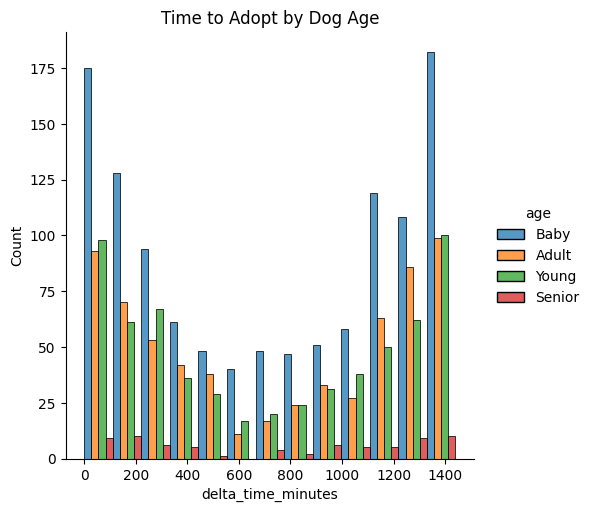

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = sns.displot(dogs_df, x='delta_time_minutes', hue='age', multiple='dodge')
fig.set(title='Time to Adopt by Dog Age')

In the above graph, Time to Adopt by Dog Age, we created a histogram, displaying how time to adoption is distributed into different buckets based on the age of the dogs. Buckets of time to adoption are on the x axis, with counts of dogs falling into that bucket on the y axis, split into different color bars by age. 

[Text(0.5, 1.0, 'Time to Adoption by Dog Color')]

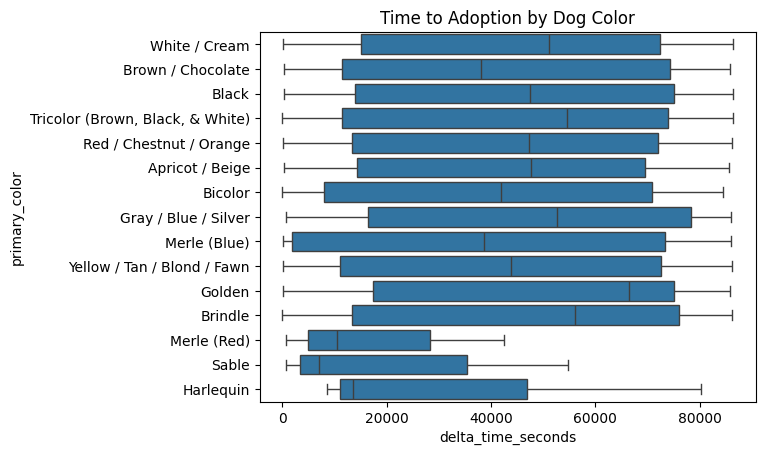

In [ ]:
fig = sns.boxplot(dogs_df, x='delta_time_seconds', y='primary_color')
fig.set(title='Time to Adoption by Dog Color')

This graph shows the distribution of time to adoption in minutes based on a dog’s coat color. To show this, we used several box and whisker plots. All of the distributions have similar spreads, although each has varying medians.

Text(0.5, 1.0, 'Compatible with dogs')

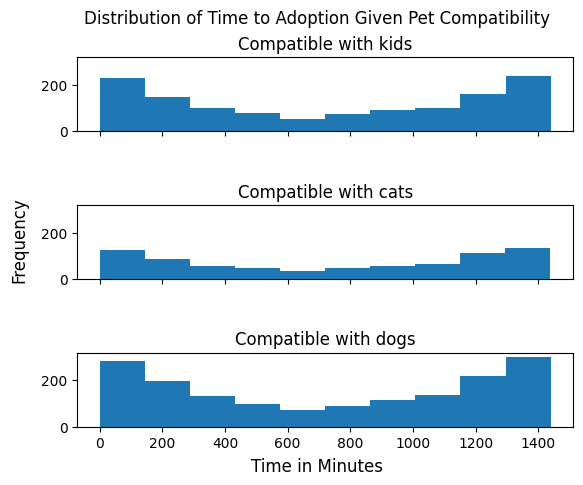

In [ ]:
dogs_w_kids = dogs_df[dogs_df['compatible_children'] == True]
dogs_w_cats = dogs_df[dogs_df['compatible_cats'] == True]
dogs_w_dogs = dogs_df[dogs_df['compatible_dogs'] == True]

fig = plt.figure()

gs = fig.add_gridspec(nrows=3, ncols=1, hspace=1)
axs = gs.subplots(sharex=True, sharey=True)

fig.suptitle('Distribution of Time to Adoption Given Pet Compatibility')
fig.supxlabel('Time in Minutes')
fig.supylabel('Frequency')

axs[0].hist(dogs_w_kids['delta_time_minutes'])
axs[0].set_title('Compatible with kids')

axs[1].hist(dogs_w_cats['delta_time_minutes'])
axs[1].set_title('Compatible with cats')

axs[2].hist(dogs_w_dogs['delta_time_minutes'])
axs[2].set_title('Compatible with dogs')

This visualization plots the distribution of time to adoption given pet compatibility including compatibility with children, compatibility with other dogs, and compatibility with cats. We plotted each within a subplot. Buckets of time to adoption are on the x axis, with counts of dogs falling into that bucket on the y axis. 

# Analysis/ML Plan

In order to determine the physical and behavioral attributes with the most influence on time to adoption, we are interested in using multivariate regression models (we will create one multivariate regression model for the physical attributes and one for the behavioral attributes). We anticipate using physical features such as ‘primary_breed’, ‘is_mixed’. ‘color’, ‘age’, ‘gender’, and ‘spayed_neutered’, as well as behavioral features such as ‘compatible_children’, ‘compatible_dogs’, and ‘compatible_cats’ in their respective models. Some of these features, such as color, are categorical, so will need to be split into boolean columns. By running a multivariate regression (we plan on testing both linear and polynomial regressions to see how it affects accuracy scores), we will be able to print out the coefficients to determine how influential each independent variable is on the dependent variable (time to adoption, or ‘time_delta’). We may experiment with which physical and behavioral features we include in our multivariate regression, by looking at a correlation matrix and observing the relationship between each attribute and delta_time. Based on this, we can run different versions of the regression with different variables included, determine which variables are most influential, and create a final model including only these influential variables. 
